In [1]:
from typing import List, Union
import pandas as pd
import numpy as np
import ast
import os
import csv
from rdkit import Chem

import optuna

import torch
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GCNConv

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt

from tqdm import tqdm

from joblib import Parallel, delayed

print(torch.cuda.is_available())  
print(torch.cuda.get_device_name(0)) 



import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_lightning.trainer.connectors.data_connector")
warnings.filterwarnings("ignore", category=UserWarning, module="lightning_fabric.plugins.environments.slurm")


torch.cuda.empty_cache()


/opt/anaconda/envs/torch_geom_2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True
NVIDIA GeForce RTX 2080 SUPER


In [2]:
class FeaturizationParameters:
    def __init__(self):
        self.max_atomic_num = 100
        self.atom_features = {
            'atomic_num': list(range(self.max_atomic_num)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }
        self.atom_fdim = sum(len(choices) + 1 for choices in self.atom_features.values()) + 2
        # skipatom
        # посмотреть какие атомные фичи есть

def onek_encoding_unk(value, choices):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1
    return encoding

def atom_features(atom, params):
    features = onek_encoding_unk(atom.GetAtomicNum() - 1, params.atom_features['atomic_num']) + \
               onek_encoding_unk(atom.GetTotalDegree(), params.atom_features['degree']) + \
               onek_encoding_unk(atom.GetFormalCharge(), params.atom_features['formal_charge']) + \
               onek_encoding_unk(int(atom.GetChiralTag()), params.atom_features['chiral_tag']) + \
               onek_encoding_unk(int(atom.GetTotalNumHs()), params.atom_features['num_Hs']) + \
               onek_encoding_unk(int(atom.GetHybridization()), params.atom_features['hybridization']) + \
               [1 if atom.GetIsAromatic() else 0] + \
               [atom.GetMass() * 0.01]  # scaled to about the same range as other features
    return features

PARAMS = {
    'BOND_FDIM': 10
}

def bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    if bond is None:
        fbond = [1] + [0] * (PARAMS['BOND_FDIM'] - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            bond.GetIsConjugated() if bt is not None else 0,
            bond.IsInRing() if bt is not None else 0
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond


class MoleculeData:
    def __init__(self, smiles, target, addHs=True):
        self.smiles = smiles
        self.target = torch.tensor(target, dtype=torch.float)
        self.mol = Chem.MolFromSmiles(smiles)
        if addHs:
            self.mol = Chem.AddHs(self.mol)
        self.params = FeaturizationParameters()
        self.edge_index, self.edge_attr = self.construct_graph()

    def construct_graph(self):
        edge_index = []
        edge_attr = []
        for bond in self.mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            edge_index.extend([[start, end], [end, start]])
            edge_attr.extend([bond_features(bond), bond_features(bond)])  # Добавляем признаки для обоих направлений связи
        return torch.tensor(edge_index).t().contiguous(), torch.tensor(edge_attr, dtype=torch.float)

    def generate_atom_features(self):
        features = []
        for atom in self.mol.GetAtoms():
            features.append(atom_features(atom, self.params))
        return torch.tensor(features, dtype=torch.float)

class MoleculeDataset(Dataset):
    def __init__(self, dataframe, smiles_column='smiles', target_column='target', addHs=True, n_jobs=-1):
        super(MoleculeDataset, self).__init__()
        self.data_list = Parallel(n_jobs=n_jobs)(
            delayed(lambda row: MoleculeData(row[smiles_column], row[target_column], addHs))(
                row) for _, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0]))

    def len(self): 
        return len(self.data_list)

    def get(self, idx):
        molecule_data = self.data_list[idx]
        x = molecule_data.generate_atom_features()
        edge_index = molecule_data.edge_index
        edge_attr = molecule_data.edge_attr
        y = molecule_data.target
        
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
        data.smiles = molecule_data.smiles
        
        return data


In [3]:
molecule_dataset = torch.load('../data/QM_137k.pt')
print(molecule_dataset)
for i in range(1):
    print(molecule_dataset[i])

MoleculeDataset(136219)
Data(x=[31, 133], edge_index=[2, 64], edge_attr=[64, 14], y=[31], smiles='CNC(=S)N/N=C/c1c(O)ccc2ccccc12')


In [4]:
class MoleculeDataModule(pl.LightningDataModule):
    def __init__(self, dataset, batch_size=128, val_split=0.1, test_split=0.2, num_workers=1):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        indices = list(range(len(self.dataset)))
        train_val_indices, test_indices = train_test_split(indices, test_size=self.test_split, random_state=42)
        train_indices, val_indices = train_test_split(train_val_indices, test_size=self.val_split / (1 - self.test_split), random_state=42)
        
        self.train_dataset = Subset(self.dataset, train_indices)
        self.val_dataset = Subset(self.dataset, val_indices)
        self.test_dataset = Subset(self.dataset, test_indices)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)



In [5]:
class MoleculeModel(pl.LightningModule):
    def __init__(self, base_model, optimizer_class, learning_rate, weight_decay, step_size, gamma, batch_size):
        super().__init__()
        self.save_hyperparameters()
        self.base_model = base_model
        self.batch_size = batch_size

        self.train_losses = []
        self.val_losses = []

    def forward(self, x, edge_index):
        return self.base_model(x, edge_index)

    def configure_optimizers(self):
        optimizer = self.hparams.optimizer_class(self.parameters(), lr=self.hparams.learning_rate, weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.hparams.step_size, gamma=self.hparams.gamma)
        return [optimizer], [scheduler]

    
    def training_step(self, batch, batch_idx):
        y_hat = self(batch.x, batch.edge_index)
        loss = F.mse_loss(y_hat, batch.y)
        self.log('train_loss', loss, batch_size=self.batch_size)
        self.train_losses.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        y_hat = self(batch.x, batch.edge_index)
        val_loss = F.mse_loss(y_hat, batch.y)
        self.log('val_loss', val_loss, batch_size=self.batch_size)
        self.val_losses.append(val_loss.item())

    def test_step(self, batch, batch_idx):
        y_hat = self(batch.x, batch.edge_index)
        preds_np = y_hat.detach().cpu().numpy()
        true_values_np = batch.y.detach().cpu().numpy()

        data = []
        start_idx = 0
        for i, num_atoms in enumerate(batch.ptr[:-1]): 
            end_idx = batch.ptr[i+1].item()
            molecule_preds = preds_np[start_idx:end_idx]
            molecule_true_values = true_values_np[start_idx:end_idx]

            data.append({
                'smiles': batch.smiles[i],
                'predictions': molecule_preds,
                'true_values': molecule_true_values
            })

            start_idx = end_idx

        return data


    def r2_score(self, y_true, y_pred):
        ss_res = torch.sum((y_true - y_pred) ** 2)
        ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2

    def test_epoch_end(self, outputs):
        all_data = [item for batch_data in outputs for item in batch_data]
        self.df_results = pd.DataFrame(all_data)

        all_predictions = np.concatenate(self.df_results['predictions'].values)
        all_true_values = np.concatenate(self.df_results['true_values'].values)

        rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
        mse = mean_squared_error(all_true_values, all_predictions)
        r2 = r2_score(all_true_values, all_predictions)
        mae = mean_absolute_error(all_true_values, all_predictions)

        print(f'RMSE: {rmse:.4f}')
        print(f'MSE: {mse:.4f}')
        print(f'R²: {r2:.4f}')
        print(f'MAE: {mae:.4f}')

        return self.df_results

In [6]:
class GATv2Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_heads, dropout_rate, activation_fn):
        super(GATv2Model, self).__init__()
        self.conv1 = GATv2Conv(in_channels=in_features, out_channels=hidden_features, heads=num_heads, dropout=dropout_rate, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_features * num_heads)
        self.conv2 = GATv2Conv(in_channels=hidden_features * num_heads, out_channels=out_features, heads=1, concat=False)
        self.activation_fn = activation_fn
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.activation_fn(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index).squeeze()
        return x


In [7]:
# Параметры модели
in_features = molecule_dataset[0].x.shape[1]
hidden_features = 64
num_heads = 8
dropout_rate = 0.006
activation_fn = F.relu  
ffn_layers = 2 # нету

# Параметры оптимизатора
optimizer_class = torch.optim.Adam  # Класс оптимизатора
learning_rate = 0.00085               # Скорость обучения
weight_decay = 2e-4                 # Коэффициент регуляризации


step_size = 50                      # Шаг уменьшения скорости обучения
gamma = 0.1                         # Коэффициент уменьшения скорости обучения

batch_size = 128                    # Размер батча
num_workers = 1                     # Количество воркеров для загрузчика данных

max_epochs = 100                     # Максимальное количество эпох
patience = 10                        # Терпение для ранней остановки

base_model = GATv2Model(
    in_features=in_features,
    hidden_features=hidden_features,
    out_features=1,
    num_heads=num_heads,
    dropout_rate=dropout_rate,
    activation_fn=activation_fn
)


data_module = MoleculeDataModule(molecule_dataset, batch_size=batch_size, num_workers=num_workers)

model = MoleculeModel(
    base_model=base_model,
    optimizer_class=optimizer_class,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    step_size=step_size,
    gamma=gamma,
    batch_size=batch_size
)

print("Model:\n", model)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=patience, verbose=True, mode='min')

trainer = pl.Trainer(
    max_epochs=max_epochs,
    enable_checkpointing = False,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[early_stop_callback],
    enable_progress_bar=False,
    logger=False
)



/opt/anaconda/envs/torch_geom_2/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'base_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['base_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Model:
 MoleculeModel(
  (base_model): GATv2Model(
    (conv1): GATv2Conv(133, 64, heads=8)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GATv2Conv(512, 1, heads=1)
  )
)


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | base_model | GATv2Model | 140 K 
------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Total params
0.561     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
Metric val_loss improved. New best score: 0.016
Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.009
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.008
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.008
Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.007
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.007
Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.006
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to s

In [9]:
df = trainer.test(model, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE: 0.0913
MSE: 0.0083
R²: 0.8077
MAE: 0.0677


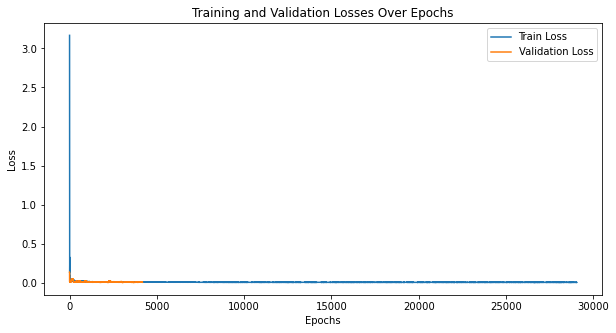

In [10]:
train_losses = model.train_losses
val_losses = model.val_losses

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

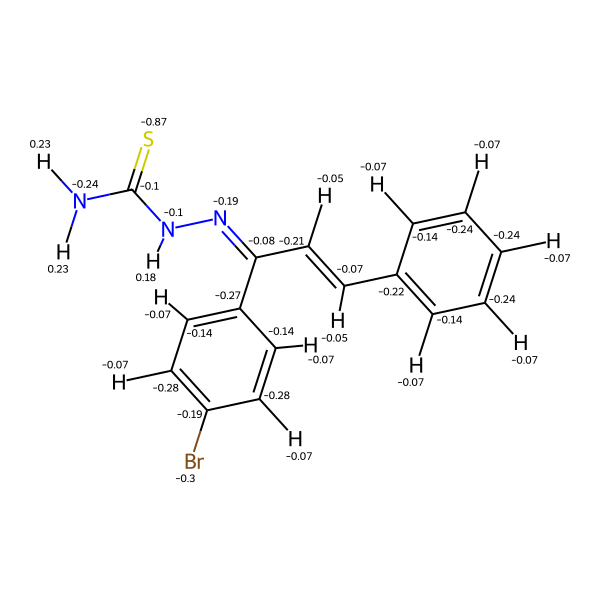

In [11]:
def draw_molecule(smiles, predictions):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    predictions_rounded = np.round(predictions, 2)

    for atom, pred in zip(mol.GetAtoms(), predictions_rounded):
        atom.SetProp('atomNote', str(pred))

    img = Chem.Draw.MolToImage(mol, size=(600, 600), kekulize=True)
    img.show()


df_results = model.df_results

smiles = df_results.iloc[0]['smiles']
predictions = df_results.iloc[0]['predictions']
draw_molecule(smiles, predictions)
